Using TensorFlow backend.


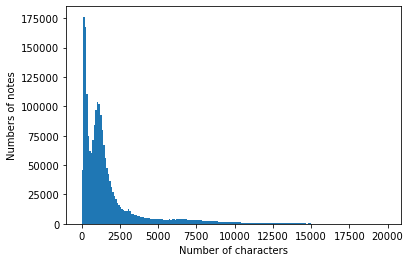

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import time

import re
import nltk
import spacy
import keras
# benchmark (i.e. time) a few tokenizers including NLTK, spaCy, and Keras
# print(re.__version__)
# print(nltk.__version__)
# print(spacy.__version__)
# print(keras.__version__)

#Data set using NOTEEVENTS.csv by MIMIC III
df_notes = pd.read_csv('./Benchmarking_Python_NLP_Tokenizers/NOTEEVENTS-2.csv')

#The notes are contained in column 'TEXT', find length of each note 
df_notes["TEXT_LEN"] = df_notes["text"].apply(len)

#plot a histogram to see a range of different lengths
plt.hist(df_notes.TEXT_LEN.values, bins = range(0,20000,100))
plt.xlabel('Number of characters')
plt.ylabel('Numbers of notes')
plt.show()


In [8]:
# Extract list of notes from pandas dataframe
notes = list(df_notes.text.values)
# To make things simplers, let's shuffle the notes in case there is an order 
import random
random.seed(42)
random.shuffle(notes)

In [9]:
# Clean Text: Lets write a few functions for each custom tokenizer
def custome_tokenize(text):
    text = clean_text(text)
    tokens = custome_tokenize(text)
    return tokens 

# Use the same cleaning fucntion with each custom tokenizer. 
# Pass all punctuation and numbers to NLTK's word_tokenize
from nltk import word_tokenize
word_tokenize("!\"#$%&'()*+,-/:;<=>?@[\]^_`{|}~0123456789")
# We casee that NLTKS splits on some punctuation but not all and nubmers are still included. Each custom tokenizer could have a slightly different rules 
"""For this NLP classification task, all punctuation and numbers should be replaced with a space — to remove it and prevent combining of two words adjacent to the punctuation. Making the assumption that single quotes tend to be included in a contraction and I would like to make [can’t] turn into [cant] instead of two tokens[can, t], so we will replace single quotes with an empty character. To accomplish this I have created the following clean_text function"""
def clean_text(text):
    # perfrom a few cleaning steps to remove non-alphabetic characters

    # replace new line and carriage return with space
    text = text.replace("\n"," ").replace("\r"," ")
    # replace the numbers and punctuation (exclude single quote) with space
    punc_list = '!"#$%&()*+,-/:;<=>?@[\]^_`{|}~' + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list," "))
    text = text.translate(t)

    # replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)

    return text
# Lets time the above function "clean_text"
for num_notes in [10,100,1000,10000,100000]:
    t1 = time.time()
    [clean_text(n) for n in notes[:num_notes]]
    t2 = time.time()
    print('num notes = ',num_notes, ',time = %.3f'%(t2-t1))
"""The results demonstrates the time for a different number of notes ending with 100000 notes taking 4.595 seconds. Note that if you run this a few times you may get slightly different numbers depending on the state of your computer."""

num notes =  10 ,time = 0.002
num notes =  100 ,time = 0.008
num notes =  1000 ,time = 0.052
num notes =  10000 ,time = 0.487
num notes =  100000 ,time = 4.614


'The results demonstrates the time for a different number of notes ending with 100000 notes taking 4.595 seconds. Note that if you run this a few times you may get slightly different numbers depending on the state of your computer.'

In [11]:
# NTLK’s word_tokenize
from nltk import word_tokenize

def nltk_tokenize(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    return tokens
nltk_times = []

# Lets time the nltk function "nltk_tokenize"
for num_notes in [10,100,1000,10000,100000]:
    t1 = time.time()
    [nltk_tokenize(n) for n in notes[:num_notes]]
    t2 = time.time()
    print('num notes = ',num_notes, ',time = %.3f'%(t2-t1))
    nltk_times.append(t2-t1)
"""That’s just disappointing: it takes 5 minutes to just tokenize 100000 notes. This is kind of annoying if you are playing with hyperparameters of a Vectorizer for your NLP Bag-of-words model. Note that the cleaning function plays a minimal role with this tokenizer (4.59 seconds out of 243 seconds). Let’s see if we can do better"""

num notes =  10 ,time = 0.039
num notes =  100 ,time = 0.304
num notes =  1000 ,time = 2.440
num notes =  10000 ,time = 24.368
num notes =  100000 ,time = 249.996


'That’s just disappointing: it takes 5 minutes to just tokenize 100000 notes. This is kind of annoying if you are playing with hyperparameters of a Vectorizer for your NLP Bag-of-words model. Note that the cleaning function plays a minimal role with this tokenizer (4.59 seconds out of 243 seconds). Let’s see if we can do better'

In [12]:
# Regular Expressions Tokenizer
import re 
WORD = re.compile(r'\w+')
def reg_tokenize(text):
    text = clean_text(text)
    words = WORD.findall(text)
    return words
reg_times = []

# Lets time the regexp function "reg_tokenize"
for num_notes in [10,100,1000,10000,100000]:
    t1 = time.time()
    [reg_tokenize(n) for n in notes[:num_notes]]
    t2 = time.time()
    print('num notes = ',num_notes, ',time = %.3f'%(t2-t1))
    reg_times.append(t2-t1)

"""NLTK word_tokenize must be adding extra bells and whistles to the tokenizer. Andrew Long was curious what was included so he looked at the source code. All he was able to learn was that it uses a tree bank tokenizer. However, looking at the source code pointed me to another tokenizer in NLTK that just uses regular expressions: regexp_tokenize."""

num notes =  10 ,time = 0.003
num notes =  100 ,time = 0.020
num notes =  1000 ,time = 0.138
num notes =  10000 ,time = 1.317
num notes =  100000 ,time = 14.066


'NLTK word_tokenize must be adding extra bells and whistles to the tokenizer. Andrew Long was curious what was included so he looked at the source code. All he was able to learn was that it uses a tree bank tokenizer. However, looking at the source code pointed me to another tokenizer in NLTK that just uses regular expressions: regexp_tokenize.'

In [13]:
#NLTK's regexp_tokenize
from nltk.tokenize.regexp import regexp_tokenize

def renltk_tokenize(text):
    text = clean_text(text)
    words = regexp_tokenize(text, pattern='\s+', gaps = True)
    return words

re_nltk_times = []
# time the regexp function "renltk_tokenize"
for num_notes in [10,100,1000,10000,100000]:
    t1 = time.time()
    [renltk_tokenize(n) for n in notes[:num_notes]]
    t2 = time.time()
    print('num notes = ',num_notes, ',time = %.3f'%(t2-t1))
    re_nltk_times.append(t2-t1)

"""slightly better than just regular expression’s implementation!"""

num notes =  10 ,time = 0.003
num notes =  100 ,time = 0.020
num notes =  1000 ,time = 0.143
num notes =  10000 ,time = 1.372
num notes =  100000 ,time = 14.358


'slightly better than just regular expression’s implementation!'

In [14]:
# spaCy tokenizer: load the ‘en’ spaCy package and disable the named entity regonition, parser and tagger. This will remove some of the default options that we don’t ultimately need and would take time if we didn’t disable them.
# NEED python -m spacy download en
import spacy
nlp = spacy.load('en_core_web_sm', disable= ['ner', 'parser', 'tagger'])

def spacy_tokenize(text):
    text = clean_text(text)
    tokens = [x.text for x in nlp(text)]
    tokens = [tok.strip() for tok in tokens]
    tokens = [tok for tok in tokens if tok != '']
    return tokens

spacy_times = []
# time the regexp function "spacy_tokenize"
for num_notes in [10,100,1000,10000,100000]:
    t1 = time.time()
    [spacy_tokenize(n) for n in notes[:num_notes]]
    t2 = time.time()
    print('num notes = ',num_notes, ',time = %.3f'%(t2-t1))
    spacy_times.append(t2-t1)
"""This isn’t as fast as the regexp tokenizers but is at least similar to NLTK’s word_tokenize"""

num notes =  10 ,time = 0.047
num notes =  100 ,time = 0.183
num notes =  1000 ,time = 1.017
num notes =  10000 ,time = 9.661
num notes =  100000 ,time = 102.472


'This isn’t as fast as the regexp tokenizers but is at least similar to NLTK’s word_tokenize'

In [15]:
# Kera’s text_to_word_sequence (a word tokenizer) 
from keras.preprocessing.text import text_to_word_sequence

def  keras_tokenizer(text):
    text = clean_text(text)
    tokens = text_to_word_sequence(text)
    return tokens

keras_times = []
# time the regexp function "keras_tokenizer"
for num_notes in [10,100,1000,10000,100000]:
    t1 = time.time()
    [keras_tokenizer(n) for n in notes[:num_notes]]
    t2 = time.time()
    print('num notes = ',num_notes, ',time = %.3f'%(t2-t1))
    keras_times.append(t2-t1)

"""It is abit similar to the regexp tokenizers. If you look under the hood you can see it is also using regexp to split. Similarly, it also has options for filtering out characters which uses the same text.translate technique we used in clean_text"""

num notes =  10 ,time = 0.003
num notes =  100 ,time = 0.015
num notes =  1000 ,time = 0.106
num notes =  10000 ,time = 1.013
num notes =  100000 ,time = 10.969


'It is abit similar to the regexp tokenizers. If you look under the hood you can see it is also using regexp to split. Similarly, it also has options for filtering out characters which uses the same text.translate technique we used in clean_text'

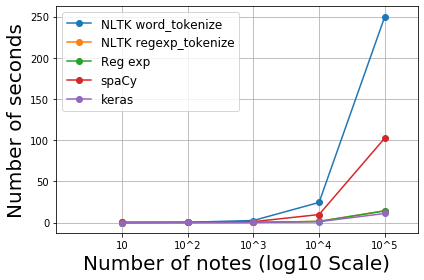

In [66]:
# NOW we plot the times for all thsese tests as shown below
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.log10([10,100,1000,10000,100000]), nltk_times, 'o-', label = 'NLTK word_tokenize')
plt.plot(np.log10([10,100,1000,10000,100000]), re_nltk_times, 'o-', label = 'NLTK regexp_tokenize')
plt.plot(np.log10([10,100,1000,10000,100000]), reg_times, 'o-', label = 'Reg exp')
plt.plot(np.log10([10,100,1000,10000,100000]), spacy_times, 'o-', label = 'spaCy')
plt.plot(np.log10([10,100,1000,10000,100000]), keras_times, 'o-', label = 'keras')


plt.xlabel('Number of notes (log10 Scale)', fontsize = 20)
plt.xticks([1,2,3,4,5], ['10','10^2','10^3','10^4','10^5'], fontsize = 10)
plt.ylabel('Number of seconds', fontsize = 20)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 12)

#plt.axis([0,6,0,15]) # plt.axis([xmin,xmax,ymin,ymax])
plt.xlim(0, 5.5) # limit showing x
# plt.ylim(0, 20)
# plt.margins(x = 0, y = 0.01)
plt.grid()

plt.tight_layout()

plt.show()
